In [54]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
from numpy import linalg as LA
from scipy.spatial import distance
import math

def get_laplacians(x, n_agents, metric, rr, ra, n_neighbors):
    A_r = np.zeros(x.shape)
    D_r = np.zeros(x.shape)
    A_a = np.zeros(x.shape)
    D_a = np.zeros(x.shape)
    
    if metric == "dist":
        for i in range(n_agents):
            for j in range(n_agents):
                if i == j:
                    continue
                dist = np.sum((x[j] - x[i]) ** 2) ** 0.5
                if dist < rr:
                    A_r[i, j] = 1
                    #A_r[j, i] = 1
                    D_r[i, i] += 1
                elif dist < ra:
                    A_a[i, j] = 1
                    #A_a[j, i] = 1
                    D_a[i, i] += 1
    elif metric == "nn":
        for i in range(n_agents):
            dists = np.zeros((n_agents))
            for j in range(n_agents):
                if i == j:
                    dists[j] = world_dim ** 2 + world_dim ** 2
                else:
                    dists[j] = np.sum((x[j] - x[i]) ** 2) ** 0.5
            indices = np.argsort(dists)[:n_neighbors]
            within_radius = False # nearest neighbor within radius UNK
            #print(dists)
            for nn in range(n_neighbors):
                idx = indices[nn]
                dist = dists[idx]
                if dist < rr: # then nearest neighbor is within radius
                    A_r[i, idx] = 1
                    #A_r[idx, i] = 1
                    D_r[i, i] += 1
                    within_radius = True
                elif not within_radius:
                    A_a[i, idx] = 1
                    #A_a[j, i] = 1
                    D_a[i, i] += 1
            if not within_radius:
                assert D_a[i,i] == n_neighbors
            else:
                assert  D_a[i,i] <= n_neighbors
                
    return D_r, A_r, D_a, A_a

def get_fiedler_ev(mtx):
    eig_vals = LA.eigvals(mtx)
    eig_vals = np.sort(eig_vals)
    non_zero = eig_vals[eig_vals>1e-10]
    if len(non_zero)==0:
        return 0
    else:
        #print(non_zero[0], eig_vals[1])
        return non_zero[0]

def is_visible(x, x_angles, point_idx, nn_idx, fop):
    # To be implemented, use point's orientation and field of perception to decide if neighbor (nn_idx) is visible
    return True
    
def target_angles(x, x_angles, r_r, r_o, r_a, fop):
    D = distance.squareform(distance.pdist(x))
    sorted_idx = np.argsort(D, axis=1)
    target_angles = np.copy(x_angles)
    # Each node now has a list of its neighbors sorted by distance
    for point_idx in range(x.shape[0]):
        nn = 1
        dist = 0
        no_repulsors, orient, attractors = True,False,False
        target_angle = np.zeros((x.shape[1]))
        has_neighbors = False
        # Iterate over neighbors until they are out of perception range (farther than ZOA reaches)
        while True:
            if nn == sorted_idx.shape[0]:
                break
                
            nn_idx = sorted_idx[point_idx, nn]
            dist = D[point_idx, nn_idx]
            if is_visible(x, x_angles, point_idx, nn_idx, fop):
                if dist < r_r:
                    no_repulsors = False
                    target_angle -= (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx])
                # Neighbors in ZOO and ZOA only take effect if there is no one in the zone of repulsion
                elif dist < r_o and no_repulsors:
                    orient = True
                    target_angle += x_angles[nn_idx] / LA.norm(x_angles[nn_idx])
                elif dist < r_a and no_repulsors:
                    attractors = True
                    target_angle += (x[nn_idx] - x[point_idx]) / LA.norm(x[nn_idx] - x[point_idx]) 
                else: 
                    break
                nn += 1
            else:
                nn += 1
                continue
        
        if not no_repulsors:
            target_angles[point_idx] = target_angle
        elif orient and attractors:
            # if there are neighbors in both attraction radius and orientation radius, 
            # take average between the two
            target_angles[point_idx] = target_angle / 2
        elif orient or attractors:
            target_angles[point_idx] = target_angle

    return target_angles

def rotate(x_angles, t_angles, turning_rate):
    for i in range(x_angles.shape[0]):
        angle = np.arccos(np.dot(x_angles[i], t_angles[i]) / 
                          (np.linalg.norm(x_angles[i]) * np.linalg.norm(t_angles[i])))
        if angle < turning_rate:
            x_angles[i] = t_angles[i]
        else:
            # TODO: Turn in direction of target_angle
            x_angles[i] = t_angles[i]
    return x_angles

def move_agents(x, x_angles, velocity):
    x += x_angles * velocity
    return x
                                     

    
    

<IPython.core.display.Javascript object>


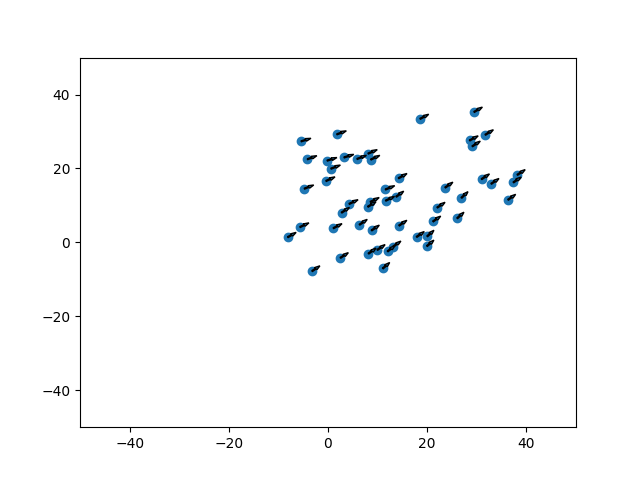

KeyboardInterrupt: 

In [57]:
%matplotlib notebook
n_agents = 50
world_dim = 100
M = world_dim / 4
n_neighbors = 5
metric = "nn" # "dist","nn"
n_timesteps = 100
turning_rate = (100 / 360) * 2 * math.pi # 100 degrees to radians. Is tune-able
x = 2 * M * (np.random.random((n_agents, 2)) - 0.5)
x_angles = np.random.random((n_agents, 2))
x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None] # direction vectors are unit vectors
fop = 2 * math.pi
velocity = 1

r_r = 1
r_o = r_r * 15
r_a = r_r * 16

plot = True
fiedler_r = []
avg_deg_r = []
fiedler_a = []
avg_deg_a = []

if plot:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    
#target_angles(x, x_angles, r_r, r_o, r_a, fop)

for step in range(n_timesteps):
    ax.clear()
    ax.scatter(x[:,0], x[:,1])
    for n in range(n_agents):
        ax.arrow(x[n,0],x[n,1],x_angles[n,0],x_angles[n,1], width=.25)
    ax.set_xlim((-world_dim / 2,world_dim / 2))
    ax.set_ylim((-world_dim / 2,world_dim / 2))
    fig.canvas.draw()

    #D_r, A_r, D_a, A_a = get_laplacians(x, n_agents, metric, r_r, r_a, n_neighbors)
    t_angles = target_angles(x, x_angles, r_r, r_o, r_a, fop)
    t_angles = t_angles / LA.norm(t_angles, axis=1)[:,None]
    x_angles = rotate(x_angles, t_angles, turning_rate)
    x_angles = x_angles / LA.norm(x_angles, axis=1)[:,None]
    x = move_agents(x, x_angles, velocity)
    
    #fiedler_r.append(get_fiedler_ev(L_r))
    #fiedler_a.append(get_fiedler_ev(L_a))
    #avg_deg_r.append(np.mean(D_r.diagonal()))
    #avg_deg_a.append(np.mean(D_a.diagonal()))
    
    plt.pause(.25)
        
print("Done")


Text(0, 0.5, 'Avg Degree of D_a')

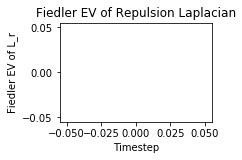

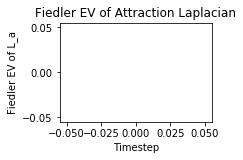

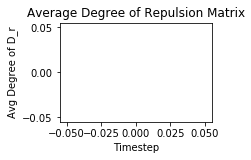

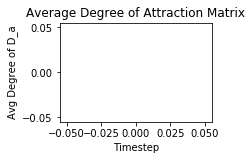

In [9]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(fiedler_r)
ax.set_title("Fiedler EV of Repulsion Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,2)
ax.plot(fiedler_a)
ax.set_title("Fiedler EV of Attraction Laplacian")
ax.set_xlabel("Timestep")
ax.set_ylabel("Fiedler EV of L_a")

fig = plt.figure()
ax = fig.add_subplot(2,2,3)
ax.plot(avg_deg_r)
ax.set_title("Average Degree of Repulsion Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_r")

fig = plt.figure()
ax = fig.add_subplot(2,2,4)
ax.plot(avg_deg_a)
ax.set_title("Average Degree of Attraction Matrix")
ax.set_xlabel("Timestep")
ax.set_ylabel("Avg Degree of D_a")